In [2]:
import pandas as pd
from dataset import Dataset
from dataread import Dataread
import seaborn as sns
import matplotlib.pyplot as plt
import os
import fsspec
import pyarrow.parquet as pq

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

ds = Dataset()
dr = Dataread()
JSON_KEY_PATH = "./sprintda05-soomin.json"
os.environ["GOOGlE_APPLICATION_CREDENTIALS"] = JSON_KEY_PATH
fs = fsspec.filesystem("gcs")


In [7]:
# day 별 
def daycounter(df):
    day0 = pd.to_datetime('2023-05-01')
    day1 = pd.to_datetime('2023-05-01') + pd.Timedelta(days=1)
    result = {}
    while True:
        mask1 = df['created_at'] > day0
        mask2 = df['created_at'] < day1
        
        try:
            result[day0.strftime('%Y-%m-%d')] = df.loc[(mask1) & (mask2), 'user_id'].nunique()
        except:
            result[day0.strftime('%Y-%m-%d')] = df.loc[(mask1) & (mask2), 'id'].nunique()
        
        if day1 >= pd.to_datetime('2023-08-01'):
            break
        day0 = day0 + pd.Timedelta(days=1)
        day1 = day1 + pd.Timedelta(days=1)

    result_df = pd.DataFrame(list(result.items()), columns=['day', 'count'])
    return result_df

In [8]:
# day 별 누적
def dayculcounter(df):
    day = pd.to_datetime('2023-05-01')
    result = {}
    while True:
        mask2 = df['created_at'] <= day
        
        try:
            result[day.strftime('%Y-%m-%d')] = df.loc[(mask2), 'user_id'].nunique()
        except:
            result[day.strftime('%Y-%m-%d')] = df.loc[(mask2), 'id'].nunique()
        
        if day >= pd.to_datetime('2023-08-01'):
            break
        day = day + pd.Timedelta(days=1)

    result_df = pd.DataFrame(list(result.items()), columns=['day', 'count'])
    return result_df

In [4]:
# 투표한 유저수 통합 테이블 구성
df = ds.votes.accounts_userquestionrecord()
reported_user_list = ds.votes.accounts_timelinereport()['reported_user_id'].unique()
vote_user_df = df.loc[df['status'] != 'B'].copy()
vote_user_df = vote_user_df.loc[vote_user_df['user_id'].isin(reported_user_list) == False]

In [5]:
vote_user_df


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1217553,161666166,C,2024-05-07 11:29:07,945560,2614,1001607,190864020,1,N,2024-05-07 11:29:07,0,0
1217554,161666461,C,2024-05-08 01:34:56,850774,1679,855525,200139931,0,N,2024-05-08 01:34:56,0,0
1217555,161666462,C,2024-05-08 01:35:02,855509,2605,855525,200139932,0,N,2024-05-08 01:35:02,0,0
1217556,161666463,C,2024-05-08 01:36:00,855526,3801,855525,200139933,0,N,2024-05-08 01:36:00,0,0


In [6]:
day_vote_user_df = daycounter(vote_user_df)
day_vote_user_df

,day,count
0,2023-05-01,324
1,2023-05-02,411
2,2023-05-03,752
3,2023-05-04,814
4,2023-05-05,1232
...,...,...
87,2023-07-27,14
88,2023-07-28,14
89,2023-07-29,17
90,2023-07-30,11


In [7]:
temp = ds.votes.accounts_user()
temp = temp.loc[temp['created_at'] < '2023-08-01']

In [8]:
cul_with_draw_df = dayculcounter(ds.votes.accounts_userwithdraw())

In [9]:
cul_user_df = dayculcounter(ds.votes.accounts_user())
cul_user_df

,day,count
0,2023-05-01,19093
1,2023-05-02,23733
2,2023-05-03,27804
3,2023-05-04,32035
4,2023-05-05,35508
...,...,...
88,2023-07-28,673090
89,2023-07-29,673121
90,2023-07-30,673146
91,2023-07-31,673161


In [10]:
cul_with_draw_df

,day,count
0,2023-05-01,2414
1,2023-05-02,2886
2,2023-05-03,3354
3,2023-05-04,3783
4,2023-05-05,4186
...,...,...
88,2023-07-28,61242
89,2023-07-29,61371
90,2023-07-30,61498
91,2023-07-31,61604


Q. withdraw한 유저가 account에 존재하는가? (탈퇴한 회원의 기록도, accounts_user 에 남아있는가의 문제. 없어졌다면, 굳이 withdraw유저의 숫자를 뺄 필요 없음.
이래저래 확신할 수 없으니 팀적으로 합의만 보면 될 듯)

In [ ]:
import matplotlib.dates as mdates

def index_maker(cul_user_df, day_vote_user_df):
    cul_user_df['day'] = pd.to_datetime(cul_user_df['day'])
    day_vote_user_df['day'] = pd.to_datetime(day_vote_user_df['day'])

    merged_df = pd.merge(cul_user_df, day_vote_user_df, on ='day', suffixes=['_user','_vote'], how = 'left')
    merged_df = merged_df.iloc[:-1]
    merged_df['ratio'] = round(merged_df['count_vote'] / merged_df['count_user'] * 100,4)
    index_graph(merged_df)
    display(merged_df)

    return merged_df

# 지표 라인 그래프 그리기
def index_graph(merged_df):
    plt.figure(figsize=(10,6))
    ax = sns.lineplot(data=merged_df, x='day', y='ratio')

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.set_title('Day별 투표율')
    ax.set_ylabel('투표율')
    ax.set_xlabel('Day')

    plt.tight_layout()
    plt.show()
    return


### 1. withdraw 유저를 빼지 않은 경우

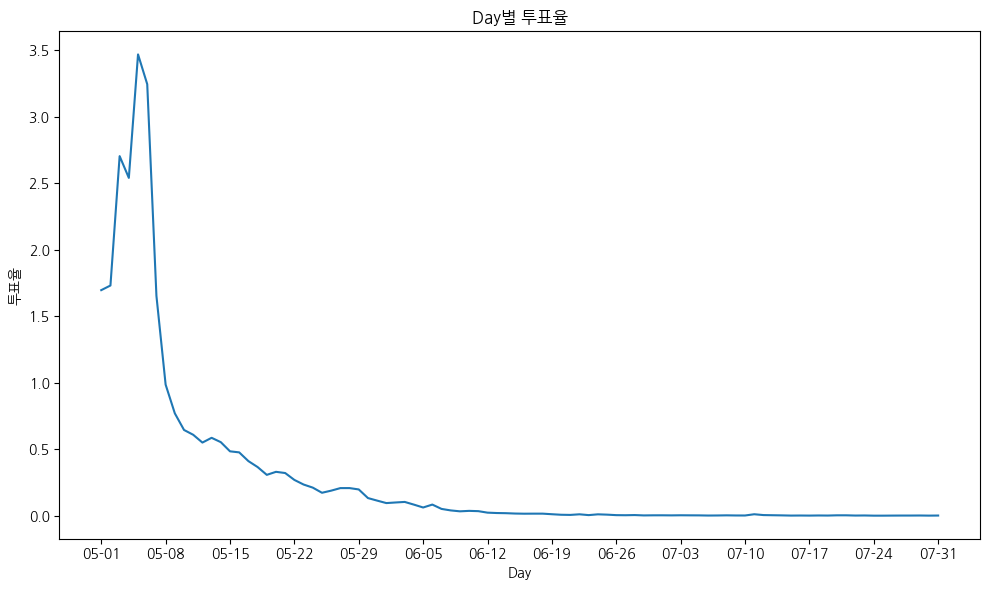

,day,count_user,count_vote,ratio
0,2023-05-01,19093,324.0,1.6970
1,2023-05-02,23733,411.0,1.7318
2,2023-05-03,27804,752.0,2.7046
3,2023-05-04,32035,814.0,2.5410
4,2023-05-05,35508,1232.0,3.4696
...,...,...,...,...
87,2023-07-27,673057,14.0,0.0021
88,2023-07-28,673090,14.0,0.0021
89,2023-07-29,673121,17.0,0.0025
90,2023-07-30,673146,11.0,0.0016


In [113]:
merged_df = index_maker(cul_user_df, day_vote_user_df)

### 2. withdraw 유저를 뺀 경우

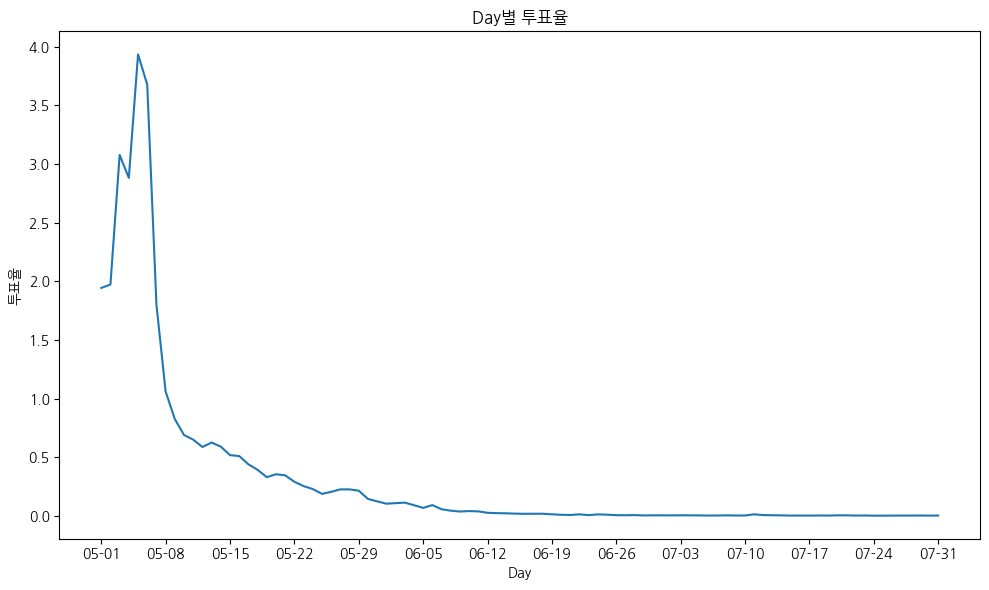

,day,count_user,count_vote,ratio
0,2023-05-01,16679,324.0,1.9426
1,2023-05-02,20847,411.0,1.9715
2,2023-05-03,24450,752.0,3.0757
3,2023-05-04,28252,814.0,2.8812
4,2023-05-05,31322,1232.0,3.9333
...,...,...,...,...
87,2023-07-27,611933,14.0,0.0023
88,2023-07-28,611848,14.0,0.0023
89,2023-07-29,611750,17.0,0.0028
90,2023-07-30,611648,11.0,0.0018


In [12]:
cul_user_withdraw_df = pd.DataFrame()
cul_user_withdraw_df['day'] = cul_user_df['day']
cul_user_withdraw_df['count'] = cul_user_df['count'] - cul_with_draw_df['count']

merged_df = index_maker(cul_user_withdraw_df, day_vote_user_df)

In [13]:
merged_df.to_csv('./vote_rate_table.csv', encoding='UTF-8', index=False)

### 3. question_set 생성한 user_uniuqe_id를 기준으로

In [ ]:

polls_qusetionset_df = ds.votes.polls_questionset()
polls_qusetionset_df = polls_qusetionset_df.loc[polls_qusetionset_df['status']=='F']
polls_qusetionset_df = polls_qusetionset_df.loc[polls_qusetionset_df['created_at'] < '2023-08-01']
day_questionset_vote_user_df = daycounter(polls_qusetionset_df)
day_questionset_vote_user_df

In [86]:
polls_qusetionset_df

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477
...,...,...,...,...,...,...
157614,20627339,"[206274151, 206274152, 206274153, 206274154, 2...",2023-07-31 15:54:15,F,2023-07-31 15:14:15,875083
157615,20627363,"[206274391, 206274392, 206274393, 206274394, 2...",2023-07-31 15:57:45,F,2023-07-31 15:17:45,1289094
157616,20627415,"[206274911, 206274912, 206274913, 206274914, 2...",2023-07-31 16:06:01,F,2023-07-31 15:26:01,1113391
157617,20627520,"[206275961, 206275962, 206275963, 206275964, 2...",2023-07-31 16:22:54,F,2023-07-31 15:42:55,852355


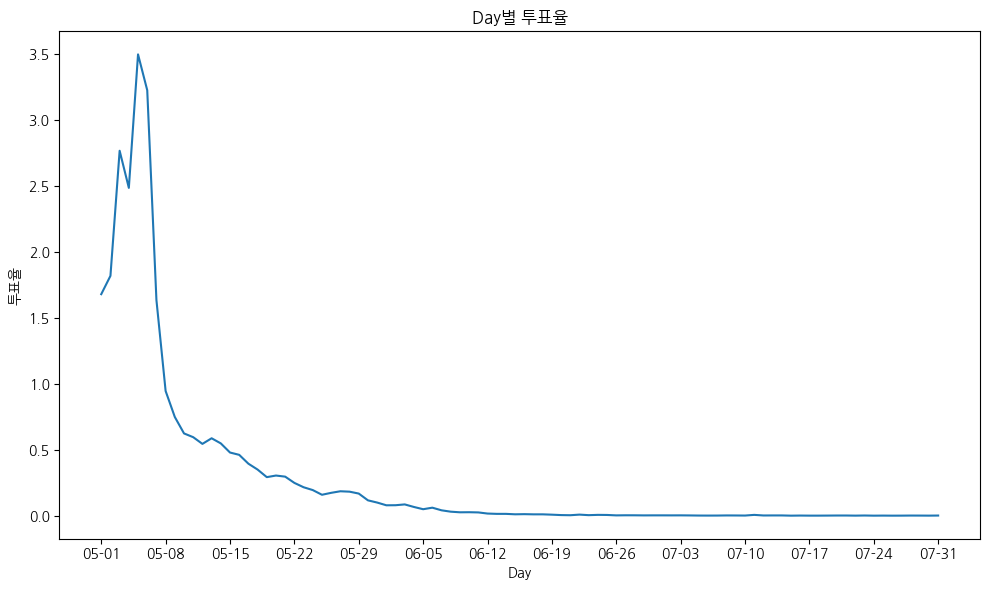

,day,count_user,count_vote,ratio
0,2023-05-01,19093,321.0,1.6812
1,2023-05-02,23733,432.0,1.8203
2,2023-05-03,27804,770.0,2.7694
3,2023-05-04,32035,797.0,2.4879
4,2023-05-05,35508,1243.0,3.5006
...,...,...,...,...
87,2023-07-27,673057,6.0,0.0009
88,2023-07-28,673090,10.0,0.0015
89,2023-07-29,673121,9.0,0.0013
90,2023-07-30,673146,6.0,0.0009


In [84]:
index_maker(cul_user_df, day_questionset_vote_user_df)
print("")

### 4. day별 attendance 를 분모로 본 경우

In [91]:
from dateutil.parser import parse
from collections import Counter
import json

accounts_attendance_df = ds.votes.accounts_attendance()

strs = accounts_attendance_df['attendance_date_list'].fillna("[]").tolist()  # NAN 값을 리스트로 처리
lists = [json.loads(s) if s != "[]" else [] for s in strs]  # JSON 문자열을 파싱하여 리스트로 변환
all_dates = [parse(dt) for sublist in lists for dt in sublist] # datetime list를 파싱하며 flatten
print(min(all_dates), max(all_dates))   # 출력해서 확인하기

# 빈도수 측정
date_counts = Counter(all_dates)

# DataFrame으로 변환 및 정렬
attendance_user_df = pd.DataFrame(date_counts.items(), columns=['day', 'count']).sort_values(by='day')
attendance_user_df = attendance_user_df.loc[attendance_user_df['day'] < '2023-08-01']
attendance_user_df['day'] = pd.to_datetime(attendance_user_df['day'])

display(attendance_user_df)


2023-05-27 00:00:00 2024-05-09 00:00:00


,day,count
0,2023-05-27,62417
1,2023-05-28,94220
2,2023-05-29,172836
3,2023-05-30,166052
40,2023-05-31,115713
...,...,...
71,2023-07-27,5799
100,2023-07-28,5972
72,2023-07-29,6047
73,2023-07-30,4723


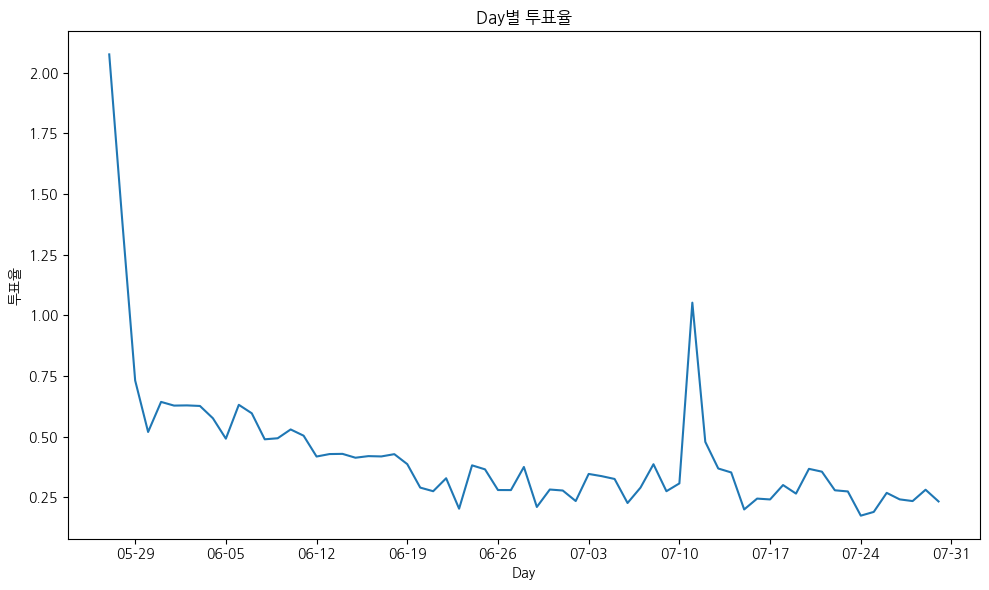

,day,count_user,count_vote,ratio
0,2023-05-27,62417,1295,2.0748
1,2023-05-28,94220,1312,1.3925
2,2023-05-29,172836,1264,0.7313
3,2023-05-30,166052,862,0.5191
4,2023-05-31,115713,744,0.6430
...,...,...,...,...
60,2023-07-26,4475,12,0.2682
61,2023-07-27,5799,14,0.2414
62,2023-07-28,5972,14,0.2344
63,2023-07-29,6047,17,0.2811


In [95]:
index_maker(attendance_user_df, day_vote_user_df)
print("")

### 검정

In [97]:
ds.votes.file_list()

['accounts_attendance',
 'accounts_blockrecord',
 'accounts_failpaymenthistory',
 'accounts_friendrequest',
 'accounts_group',
 'accounts_nearbyschool',
 'accounts_paymenthistory',
 'accounts_pointhistory',
 'accounts_school',
 'accounts_timelinereport',
 'accounts_user',
 'accounts_user_contacts',
 'accounts_userquestionrecord',
 'accounts_userwithdraw',
 'event_receipts',
 'events',
 'polls_question',
 'polls_questionpiece',
 'polls_questionreport',
 'polls_questionset',
 'polls_usercandidate']

In [101]:
ds.votes.polls_questionpiece()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0
...,...,...,...,...,...
1265471,208385226,0,2024-05-07 11:32:30,960,0
1265472,208385227,0,2024-05-07 11:32:30,1402,0
1265473,208385228,0,2024-05-07 11:32:30,1676,0
1265474,208385229,0,2024-05-07 11:32:30,3115,0


In [104]:
polls_questionset_df = ds.votes.polls_questionset()
polls_questionset_df

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477
...,...,...,...,...,...,...
158379,20838253,"[208383291, 208383292, 208383293, 208383294, 2...",2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933
158380,20838344,"[208384201, 208384202, 208384203, 208384204, 2...",2024-05-06 11:38:20,C,2024-05-06 10:58:20,876072
158381,20838419,"[208384951, 208384952, 208384953, 208384954, 2...",2024-05-07 00:55:00,C,2024-05-07 00:15:00,1208878
158382,20838445,"[208385211, 208385212, 208385213, 208385214, 2...",2024-05-07 12:09:08,C,2024-05-07 11:29:08,1001607


전체기간, question_에 기록된 user_id가 user_account에 전부 존재하는지 검증
 -> 투표 후 탈퇴한 사람이 있는가? 그런 유저가 account에 남아있는가 남아있지 않은가?


In [ ]:
question_id = polls_questionset_df.user_id.unique()

In [ ]:
account_id = ds.votes.accounts_user.id.unique()

In [111]:
account_id

array([ 831956,  831962,  832151, ..., 1583731, 1583732, 1583733])

In [112]:
set(question_id).issubset(account_id)

True

### KPI 수정

In [5]:
group_df = ds.votes.accounts_group().rename(columns={'id':'group_id'})

qusetion_record = (
    ds.votes.accounts_userquestionrecord()[['id','status','created_at','user_id','chosen_user_id']]
    .query("created_at < '2023-08-01' and created_at >= '2023-05-01'")
    # .query("status != 'B'")
    # .query("user_id not in @reported_user_list")
)


user_df = (
    ds.votes.accounts_user()[['id','created_at','group_id']]
    .query("created_at < '2023-08-01'")
    # .query("id not in @reported_user_list")
    )

user_school = pd.merge(user_df, group_df[['group_id','school_id']], on='group_id', how='left').rename(columns={'id':'user_id'})

qusetion_record_school = pd.merge(
    user_school[['user_id','school_id']],
    qusetion_record,
    on='user_id',
    how='right'
)

school_list = qusetion_record_school.school_id.unique()
user_school = user_school.loc[user_school['school_id'].isin(school_list)]

In [6]:
user_school.to_csv('./user_school.csv', encoding='UTF-8', index=False)
qusetion_record_school.to_csv('./qusetion_record_school.csv', encoding='UTF-8', index=False)

In [ ]:
quse_result = daycounter(qusetion_record_school)
user_result = dayculcounter(user_school)

# 함수 설계 이슈로, 5월 2일 데이터에 5월 1일까지의 누적 가입자수가 반영되는 문제가 있어서 수동으로 해결했다.
user_result['day'] = pd.to_datetime(user_result['day'])
user_result = user_result.iloc[1:]
user_result['day'] = user_result['day'] - pd.Timedelta(days=1)

In [ ]:
quse_result['day'] = pd.to_datetime(quse_result['day'])

result = pd.merge(
    quse_result,
    user_result,
    on='day',
    how='left',
    suffixes=['_vote','_user']
)
result['ratio'] = round(result['count_vote'] / result['count_user'] * 100,4)

In [ ]:
result

,day,count_vote,count_user,ratio
0,2023-05-01,325,446,72.8700
1,2023-05-02,413,545,75.7798
2,2023-05-03,756,934,80.9422
3,2023-05-04,820,1118,73.3453
4,2023-05-05,1248,1552,80.4124
...,...,...,...,...
87,2023-07-27,14,5074,0.2759
88,2023-07-28,14,5074,0.2759
89,2023-07-29,17,5074,0.3350
90,2023-07-30,11,5074,0.2168
